# AirBnB Pricing Analysis

### What trends can you find in the Airbnb rental calendar over time, and how might these be explained by listing-specific and/or neighborhood-level factors?

## Libraries Used

In [1]:
import numpy as np
import pandas                as pd
import matplotlib.pyplot     as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api         as sm
import scipy

## Uploading Dataset and Exploring its Attributes

In order to answer our main question, we will need to find the right dataset for us to perform an analysis. As the question directly talks about rental calendar, and listing specific and/or neighbourhood-level factors, clearly we will need the calendar and listings dataset. We will also take a look at the rows and columns of each data set to get a good gauge on how much data we are dealing with.

In [3]:
calendar = pd.read_csv("Data/calendar.csv")
listings = pd.read_csv("Data/listings.csv")
print("calendar shape:", calendar.shape)
print("listing shape:", listings.shape)

calendar shape: (21841235, 5)
listing shape: (59824, 29)


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59824 entries, 0 to 59823
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   accommodates                 59763 non-null  float64
 1   amenities                    59824 non-null  object 
 2   availability_30              59824 non-null  int64  
 3   bathrooms                    59622 non-null  float64
 4   bed_type                     59824 non-null  object 
 5   bedrooms                     59729 non-null  float64
 6   beds                         59715 non-null  float64
 7   cancellation_policy          59824 non-null  object 
 8   city                         59778 non-null  object 
 9   has_availability             0 non-null      float64
 10  host_id                      59824 non-null  int64  
 11  id                           59824 non-null  int64  
 12  instant_bookable             59824 non-null  object 
 13  latitude        

In [5]:
listings.isnull().mean()*100

accommodates                     0.101966
amenities                        0.000000
availability_30                  0.000000
bathrooms                        0.337657
bed_type                         0.000000
bedrooms                         0.158799
beds                             0.182201
cancellation_policy              0.000000
city                             0.076892
has_availability               100.000000
host_id                          0.000000
id                               0.000000
instant_bookable                 0.000000
latitude                         0.000000
longitude                        0.000000
metropolitan                     0.000000
name                             0.068534
price                            0.000000
property_type                    0.006686
review_scores_checkin           23.980342
review_scores_cleanliness       23.870019
review_scores_communication     23.878377
review_scores_location          23.985357
review_scores_rating            23

- Accommodates can give us some good info on how the pricing works. We could replace them with "unknown".
- .33% of the data for bathrooms are unavailable. Although this may affect prices, we will not keep this variable in our analysis.
- availability_30 might be useful for our analysis
- Bedrooms are definitely a factor when it comes to prices, especially in certain cities/neighbourhoods. We will replace the nulls with "unknown".
- We will ignore beds, as bedrooms is a good indicator.
- Cancellation_policy will not be useful for our analysis.
- City is obviously important, however 7% of the data is null, we can replace these with "unknown" as well.
- Has_availability has all NAs in it. Seems to be useless for our analysis as we have no info from any of the rows. We will drop this column.
- Host_id is useless to us as we are able to identify the property based on the id in both listings and calendar. Will be dropped.
- ID is super important for merging both data files!
- instant_bookable could be a big factor for prices in various neighbourhoods. Will keep it for analysis.
- latitude and longitude could be helpful for EDA analysis. Will keep it.
- metropolitan is super important!
- name is not really relevant for our analysis.
- Price is super important to see trends in prices!
- We will only keep review_scores_location, review_scores_value and review_scores_rating in our analysis and remove the rest of the reviews, as we are more focused on location for our analysis. For the 23% nulls, we will need to make the reviews with the median of their respective columns.
- Room_type can be a big factor for pricing in various neighbourhoods! Will keep it
- State can be important, although we are more focused on cities and metropolitans.
- There is weekly price, which may be useful, but there is 70% of the data missing. We can either replace the nulls with "unknown" or drop it. Since it is not a categorical variable, it is safe to drop it from our analysis. We already have prices from the calendar, which will give us a good indication of how the prices fluctuate.
- zipcode could be useful for our analysis, however 1% of the data is missing, we could drop those locations.

In [6]:
listings_dropCols = ['bathrooms', 'beds', 'cancellation_policy', 'has_availability', 'host_id', 'name',
                     'review_scores_cleanliness', 'review_scores_communication','review_scores_checkin' ,'weekly_price',
                     'amenities']
listings.drop(listings_dropCols, inplace= True, axis = 1)
### Dealing with NAs
unknowns = ['accommodates', 'bedrooms', 'city']
listings[unknowns] = listings[unknowns].fillna("unknown")
reviews = ['review_scores_location', 'review_scores_value', 'review_scores_rating']
listings[reviews] = listings[reviews].fillna(listings[reviews].median())
listings = listings.dropna()

In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58994 entries, 0 to 59823
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            58994 non-null  object 
 1   availability_30         58994 non-null  int64  
 2   bed_type                58994 non-null  object 
 3   bedrooms                58994 non-null  object 
 4   city                    58994 non-null  object 
 5   id                      58994 non-null  int64  
 6   instant_bookable        58994 non-null  object 
 7   latitude                58994 non-null  float64
 8   longitude               58994 non-null  float64
 9   metropolitan            58994 non-null  object 
 10  price                   58994 non-null  float64
 11  property_type           58994 non-null  object 
 12  review_scores_location  58994 non-null  float64
 13  review_scores_rating    58994 non-null  float64
 14  review_scores_value     58994 non-null

In [8]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21841235 entries, 0 to 21841234
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   listing_id  int64  
 1   date        object 
 2   available   object 
 3   price       float64
 4   metro_area  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 833.2+ MB


In [9]:
calendar.isnull().mean()*100

listing_id     0.000000
date           0.000000
available      0.000000
price         60.540455
metro_area     0.000000
dtype: float64

- As the output indicates, we are missing 60.54% of the prices. We will need to fix this in our data cleaning section. We can use the prices from the listings dataset to replace those null values.
- We already have metro data from our listings' data. We can remove this column.

## Data Processing and Merging

First thing we could do is to make sure that both datasets have the right ids and that they match up. In the case that one of the datasets has extra, we will eliminate those since it is only 844 out of the 59838 ids compared to the 58994 ids we have. It will not harm us as we go on further in our data analysis

In [10]:
#How many unique ids in both listings and calendar
print("Unique IDS: ")
print("Calendar: ", calendar['listing_id'].nunique())
print("Listings: ", listings['id'].nunique())

## Renaming listing_id in calendar to id
calendar.rename(columns = {'listing_id':'id'}, inplace = True)

## Making sure both ids in the datasets are equal
## Removed 14 ids in the calendar list
ids = listings['id'].tolist()
calendar1 = calendar[calendar['id'].isin(ids)]

print("\nUpdated Unique IDS: ")
print("Calendar: ", calendar1['id'].nunique())
print("Listings: ", listings['id'].nunique())

Unique IDS: 
Calendar:  59838
Listings:  58994

Updated Unique IDS: 
Calendar:  58994
Listings:  58994


Since our calendar has dates data, we can use this to our advantage to plot based on months, days and years for our analysis. Let us convert this using the ```pd.to_datetime``` function.

In [11]:
calendar1['datetime'] = pd.to_datetime(calendar1['date'], format="%Y-%m-%d")
calendar1['year'] = calendar1['datetime'].dt.year
calendar1['month'] = calendar1['datetime'].dt.month
calendar1['day'] = calendar1['datetime'].dt.dayofweek

### Upper casing the metro areas of both datasets
calendar1['metro_area'] = calendar1['metro_area'].str.upper()
listings['metropolitan'] = listings['metropolitan'].str.upper()

/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_21610/1378366689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar1['datetime'] = pd.to_datetime(calendar1['date'], format="%Y-%m-%d")
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_21610/1378366689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar1['year'] = calendar1['datetime'].dt.year
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_21610/1378366689.py:3: SettingWithCopyWarning: 
A value is trying to b

### Merging Two Datasets into One

Now that we have cleaned both datasets a bit, we will proceed to merge both datasets, into one so that we can perform a full analysis on one dataset rather than complicating it. We call this new dataset as ```listings_calendar```.

After we merge the datasets, we can do some more data cleaning:
- First we will convert the ids into a string, so that it won't be confused as a number.
- replace the missing prices from our calendar data with the prices from the listing data. Although it would be great to see how the prices fluctuate over time, we are unable to see this. Hence, the best bet to deal with the NAs is to just put the price based of the listings.
- Replace the "t" to "Yes" and "f" to "No" in the ```available```  and ```instant_bookable ```columns.
- metro_area and price_listings is not needed since we have another column with the exact same info.

In [12]:
### MERGING listings into calendar
listings_calendar = calendar1.merge(listings, on = 'id')

### Renaming and making ID string
renames = {'price_x': 'price_calendar', 'price_y' : 'price_listings'}
listings_calendar.rename(columns = renames, inplace = True)
listings_calendar = listings_calendar.astype({'id':'string'})

### Filling the NAs in price_calendar with the prices from our previous listing dataset
listings_calendar.price_calendar.fillna(listings_calendar.price_listings, inplace= True)

### Replacing "t" with "Yes" and "f" with "No"
def Replacer(col):
    try:
        if 't' in col:
            col = col.replace('t', 'Yes')
            return col
        elif 'f' in col:
            col = col.replace('f', 'No')
            return col
    except:
        return col
        
listings_calendar['available'] = listings_calendar['available'].apply(lambda ele: Replacer(ele))
listings_calendar['instant_bookable'] = listings_calendar['instant_bookable'].apply(lambda ele: Replacer(ele))
### Remove metro_area
listings_calendar.drop(['metro_area', 'price_listings'], inplace = True, axis = 1)

Great! Now let us take a look at our official updated listings_calendar dataset.



In [16]:
listings_calendar.head()

,id,date,available,price_calendar,datetime,year,month,day,accommodates,availability_30,...,latitude,longitude,metropolitan,property_type,review_scores_location,review_scores_rating,review_scores_value,room_type,state,zipcode
0,2515,2018-03-05,Yes,69.0,2018-03-05,2018,3,0,2.0,5,...,40.799205,-73.953676,NYC,Apartment,9.0,92.0,9.0,Private room,NY,10026.0
1,2515,2018-03-04,Yes,69.0,2018-03-04,2018,3,6,2.0,5,...,40.799205,-73.953676,NYC,Apartment,9.0,92.0,9.0,Private room,NY,10026.0
2,2515,2018-03-03,Yes,69.0,2018-03-03,2018,3,5,2.0,5,...,40.799205,-73.953676,NYC,Apartment,9.0,92.0,9.0,Private room,NY,10026.0
3,2515,2018-03-02,Yes,69.0,2018-03-02,2018,3,4,2.0,5,...,40.799205,-73.953676,NYC,Apartment,9.0,92.0,9.0,Private room,NY,10026.0
4,2515,2018-03-01,Yes,69.0,2018-03-01,2018,3,3,2.0,5,...,40.799205,-73.953676,NYC,Apartment,9.0,92.0,9.0,Private room,NY,10026.0


In [17]:
listings_calendar.describe()

,price_calendar,year,month,day,availability_30,latitude,longitude,review_scores_location,review_scores_rating,review_scores_value
count,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07,2.153318e+07
mean,1.638610e+02,2.017260e+03,6.526027e+00,2.998181e+00,7.976337e+00,4.065138e+01,-7.668815e+01,9.590779e+00,9.407102e+01,9.531299e+00
std,2.452814e+02,5.322162e-01,3.447851e+00,1.998019e+00,1.005923e+01,8.628509e-01,7.161145e+00,7.499536e-01,7.257777e+00,8.043124e-01
min,0.000000e+00,2.016000e+03,1.000000e+00,0.000000e+00,0.000000e+00,3.882340e+01,-1.050946e+02,2.000000e+00,2.000000e+01,2.000000e+00
25%,7.200000e+01,2.017000e+03,4.000000e+00,1.000000e+00,0.000000e+00,4.067371e+01,-7.698215e+01,9.000000e+00,9.300000e+01,9.000000e+00
50%,1.100000e+02,2.017000e+03,7.000000e+00,3.000000e+00,3.000000e+00,4.072219e+01,-7.397302e+01,1.000000e+01,9.600000e+01,1.000000e+01
75%,1.800000e+02,2.018000e+03,1.000000e+01,5.000000e+00,1.300000e+01,4.079210e+01,-7.394273e+01,1.000000e+01,9.800000e+01,1.000000e+01
max,2.000000e+04,2.018000e+03,1.200000e+01,6.000000e+00,3.000000e+01,4.238998e+01,-7.100010e+01,1.000000e+01,1.000000e+02,1.000000e+01


## Exploratory Data Analysis

Let us gain a good insight on how many data points we are dealing with in each metropolitan. Below is a bar plot on how many data points we have for each metropolitan area.

Text(0.5, 1.0, 'Property ID counts in Each Metropolitan Area')

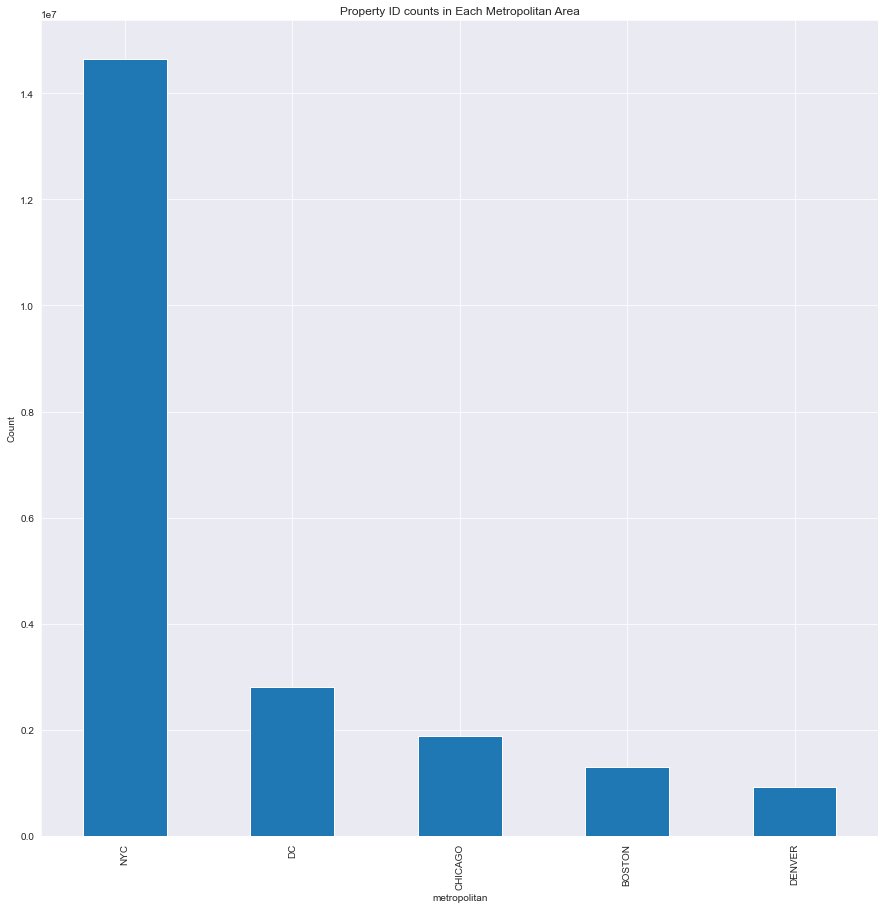

In [57]:
plt.figure(figsize=(15,15))
listings_calendar.groupby(['metropolitan'])['id'].count().sort_values(ascending=False).plot(kind = 'bar')
plt.ylabel("Count")
plt.title("Property ID counts in Each Metropolitan Area")

Below is a histogram of all the prices we have from our calendar data. Clearly most of the data revolves around the 0 to 200 dollars with outliers that are greater than 2000 dollars.

Text(0.5, 1.0, 'Histogram of Calendar Prices')

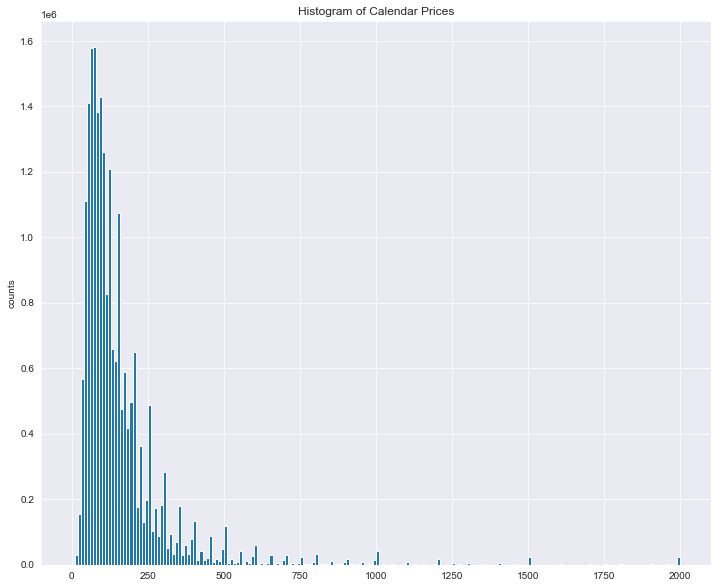

In [58]:
plt.figure(figsize=(12,10))
plt.hist(listings_calendar['price_calendar'],range=(0,2000), bins=200, density= False)
plt.ylabel("counts")
plt.title("Histogram of Calendar Prices")

Here is a pie chart showing how many data points we have in our dataset in the 3 years. Clearly, most of our information will be coming from the year of 2017.

Text(0.5, 1.0, 'Data Percentage from 2016-2018')

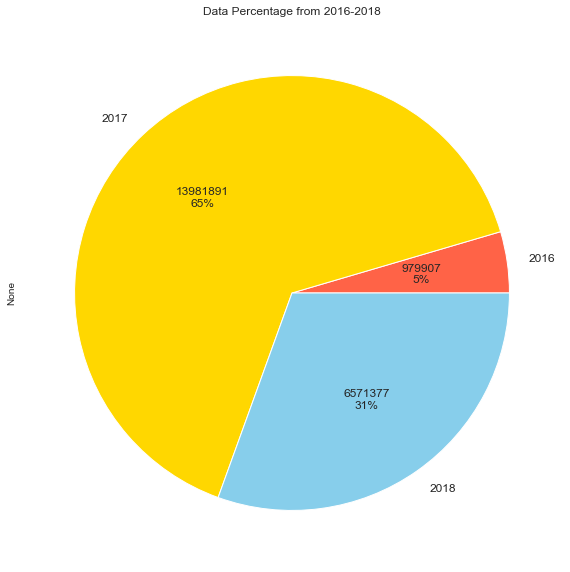

In [59]:
def label_function(val):
    return f'{val / 100 * len(listings_calendar):.0f}\n{val:.0f}%'
plt.figure(figsize=(12,10))
listings_calendar.groupby('year').size().plot(kind = 'pie', autopct = label_function, textprops = {'fontsize': 12}, colors = ['tomato', 'gold', 'skyblue'])
plt.title("Data Percentage from 2016-2018")

Now let us look at which is the most expensive metropolitan area on average.

Text(0, 0.5, 'Average Prices')

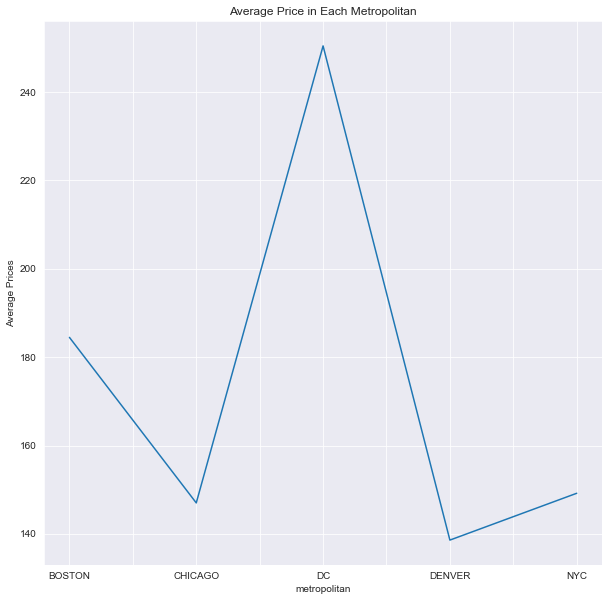

In [60]:
plt.figure(figsize=(10,10))
listings_calendar.groupby(['metropolitan'])['price_calendar'].mean().plot(kind = 'line')
plt.title("Average Price in Each Metropolitan")
plt.ylabel('Average Prices')

This is quite interesting to see that the most expensive area for airbnb in our dataset would be in DC metropolitan area. We should take a closer look at which neighbourhoods are the most expensive as well.

Since we have 5 metropolitan data, it is best to make them into seperate datasets based on the metros.

In [61]:
NY = listings_calendar.loc[listings_calendar['metropolitan'] == 'NYC']
DC = listings_calendar.loc[listings_calendar['metropolitan'] == 'DC']
Chicago = listings_calendar.loc[listings_calendar['metropolitan'] == 'CHICAGO']
Boston = listings_calendar.loc[listings_calendar['metropolitan'] == 'BOSTON']
Denver = listings_calendar.loc[listings_calendar['metropolitan'] == 'DENVER']

Now that we have seperated our data based on metropolitan, why don't we take a look at how the prices fluctuate based on time. We will seperate them by year, month and days of the week.

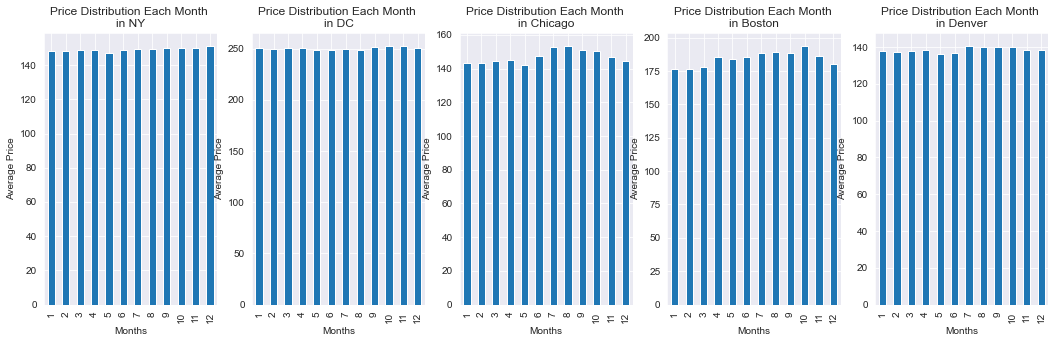

In [62]:
metro = [NY, DC, Chicago, Boston, Denver]
names = ['NY', 'DC', 'Chicago', 'Boston', 'Denver']
# #Year
# plt.figure(figsize = (18,5))
# for i, var in enumerate(metro):
#     plt.subplot(1,5,i+1)
#     city = var.groupby(['year'])['price_calendar'].mean()
#     city.plot(kind = "bar")
#     plt.title(f"Price Distribution Each Month \nin {names[i]}")
#     plt.xlabel("Year")
#     plt.ylabel('Average Price')
#Months
plt.figure(figsize = (18,5))
for i, var in enumerate(metro):
    plt.subplot(1,5,i+1)
    city = var.groupby(['month'])['price_calendar'].mean()
    city.plot(kind = "bar")
    plt.title(f"Price Distribution Each Month \nin {names[i]}")
    plt.xlabel("Months")
    plt.ylabel('Average Price')
# #Days of the Week
# plt.figure(figsize = (18,5))
# for i, var in enumerate(metro):
#     plt.subplot(1,5,i+1)
#     city = var.groupby(['day'])['price_calendar'].mean()
#     city.plot(kind = "bar")
#     plt.title(f"Price Distribution Each Month \nin {names[i]}")
#     plt.xlabel("Days of the Week")
#     plt.ylabel('Average Price')

These plots indicate how well they do in a span of either year, month or days of the week. We have separated them into 5 sections which match to the metropolitan areas. They all exhibit very similar trends.

Year:
- Very little change in the price.

Month:
- Month clearly seems to show some sort of cyclical trend, especially in Chicago. We see the prices rise during the summer period, but reduce when it's closer to november/december.

Days:
- Pretty stable, no clear trend discovered. Slight increase in the price when it comes to the weekend. This is evident in the Chicago and Denver plots.

## Explore the neighbourhoods in each metropolitan.

### Can we see trends over time across expensive neighbourhoods  in each Metropolitan and can their prices be justified?

Now that we have a general idea of the biggest neighbourhoods, an important question is which neighbourhoods in each metropolitan area is most expensive? We could be able to answer the question as to why these neighbourhoods are considered to be expensive and what trends do we see in these area that influence the prices.

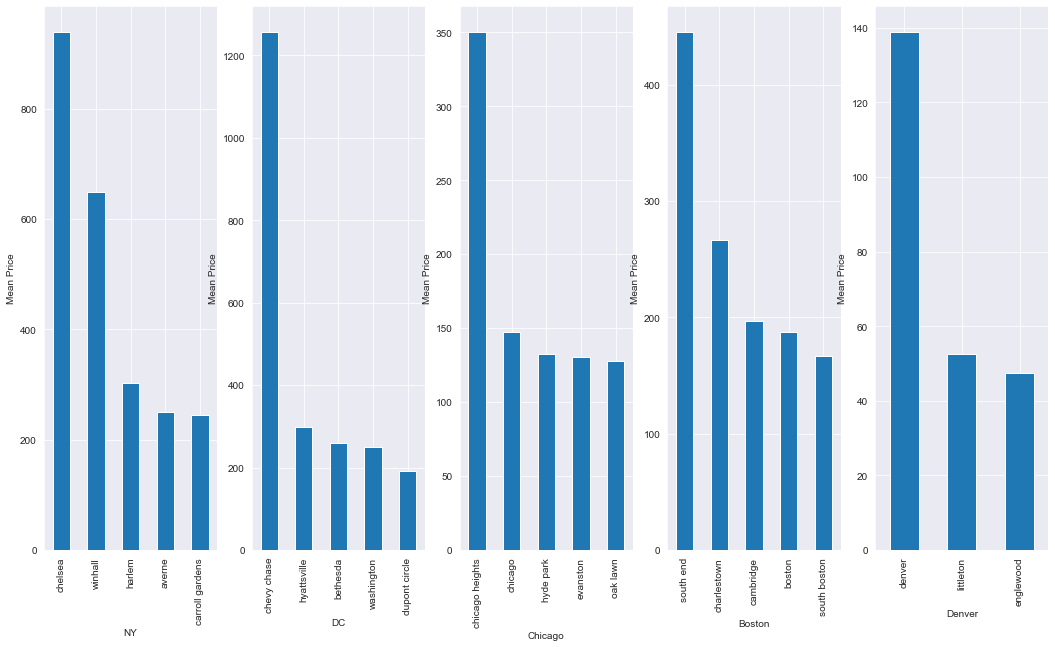

In [63]:
metro = [NY, DC, Chicago, Boston, Denver]
names = ['NY', 'DC', 'Chicago', 'Boston', 'Denver']

plt.figure(figsize = (18,10))
for i, var in enumerate(metro):
    plt.subplot(1,5,i+1)
    city = var.groupby(['city'])['price_calendar'].mean().sort_values(ascending = False)[:5]
    city.plot(kind = "bar")
    # plt.title(f"Most expensive neighbourhood \nin {names[i]}")
    plt.xlabel(names[i])
    plt.ylabel('Mean Price')

Very interesting results show up in these plots.

**New York: Chelsea**
This is quite interesting because we would assume that New York neighbourhood area would have the most expensive Airbnb, however this is not true. This neighbourhood could be for the richer folks, or water facing, or other features that can increase the price.

When looking on Google about this area, we can see that it contains luxury high-rises and trendy attractions like High Line. Furthermore, this is one of the best places to live in New York according to several websites.

**DC: Chevy Chase**

Chevy Chase is a neighbourhood in the northwest of Washington. This is also quite surprising because this is not in the heart of Washington where many people visit for tourism etc. The key features of this area, based on Google, is that it has a strong sense of community, the lifestyle is quite laid back compared to the city, and features more single family homes rather than condos. This can be of great interest as to why a suburban neighbourhood area would be more expensive than renting an airbnb in the heart of Washington.

When it comes to the DC data set, we can clearly see that the neighbourhood of Chevy Chase is a big difference in prices compared to the rest of the top 10 neighbourhoods in terms of prices. This neighbourhood may have influenced the earlier plot on where we found the DC metropolitan area the most expensive on average. Maybe it would be benefical to look at mode or median rather than average?

**Chicago: Chicago Heights (also known as Heights)**

Heights is a suburb of Chicago, about 30 miles south of downtown. To me, this is also another interesting feature, since it is not in the heart of Chicago city. One key feature about this neighbourhood is that it is not the safest community in America in general (according to Google). This is quite unexpected, why people would want to pay higher in such area. There may be some discrepancies with this data.

**Boston: South End**

South End is a neighborhood in the heart of Boston. It is distinguished from other neighbourhoods by its Victorian-style houses and many parks around the area. It has many features that well explain why rent in this area is quite high.

**Denver: Denver**
As expected, Denver (which is the only major city in Colorado) has the highest rental prices in Denver.

Let us explore these expensive neighbourhoods even further. We will first see on average, how much do they charge over each month (took a look at year and date and didn't see much trend).

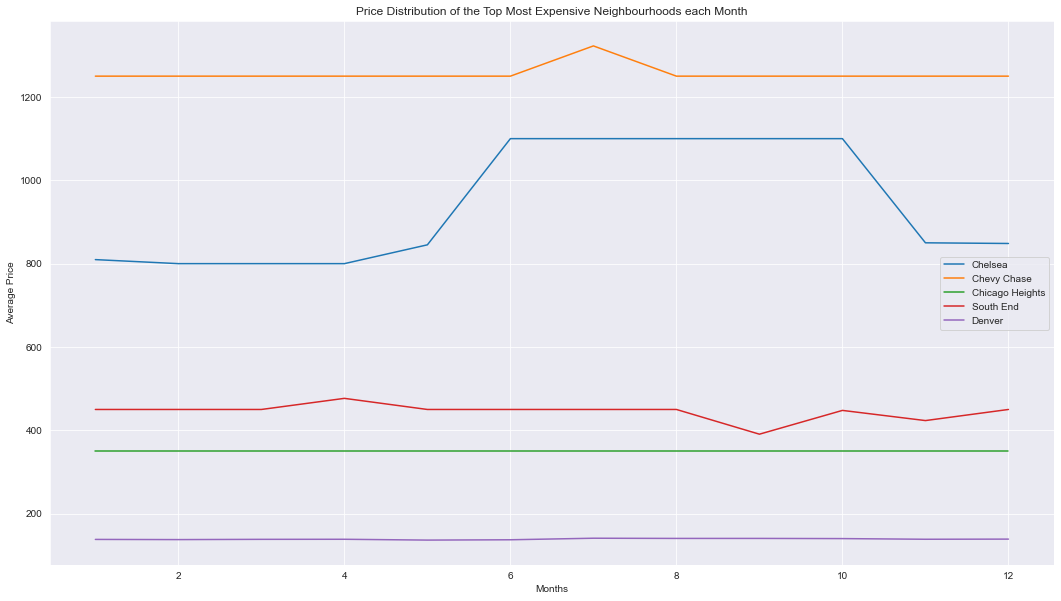

In [64]:
chelsea = NY[NY['city'] == 'chelsea'].reset_index(drop = True)
chevyChase = DC[DC['city'] == 'chevy chase'].reset_index(drop = True)
chicagoHeights = Chicago[Chicago['city'] == 'chicago heights'].reset_index(drop = True)
southEnd = Boston[Boston['city'] == 'south end'].reset_index(drop = True)
denver = Denver[Denver['city'] == 'denver'].reset_index(drop = True)

expensiveNeighbourhoods = [chelsea, chevyChase, chicagoHeights, southEnd, denver]
names = ['Chelsea', 'Chevy Chase', 'Chicago Heights', 'South End', 'Denver']

plt.figure(figsize = (18,10))
for i, var in enumerate(expensiveNeighbourhoods):
    city = var.groupby(['month'])['price_calendar'].mean()
    city.plot(kind = "line")
    plt.title(f"Price Distribution of the Top Most Expensive Neighbourhoods each Month")
    plt.xlabel("Months")
    plt.ylabel('Average Price')
    plt.legend(names)

**Chelesea**
Clearly there is a huge increase in the prices when it comes to the summer months (May-September), and then falls drastically in the other months.

**Chevy Chase**
There is an increase in price when it comes to summer of (June-July). Other than that, the price is quite stable throughout the rest of the months.

**Chicago Heights**
Months does not affect the price

**South End**
Certain month(s) the price is high (around February time) while around August-September there is a huge price reduction, and then comes back up. Seems like the data is not very consistent in this setting.

**Denver**
Similar trend to how it was in Chelsea, summer is the peak price. However, it must be noted that there is an increase during December time? Possibly due to New Years/Christmas? Furthermore, during the time between February till May, there is a loss in price.

Now that we know how when the peak prices are for each of these expensive neighbourhoods, are these properties available or are they constantly being booked? Let us find out.

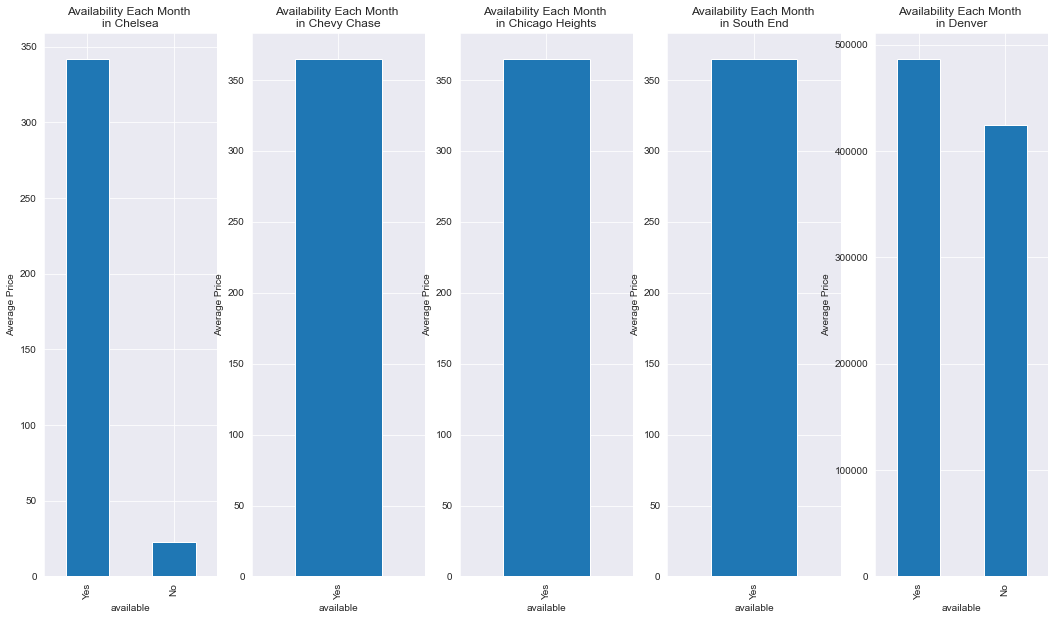

In [29]:
expensiveNeighbourhoods = [chelsea, chevyChase, chicagoHeights, southEnd, denver]
names = ['Chelsea', 'Chevy Chase', 'Chicago Heights', 'South End', 'Denver']
plt.figure(figsize = (18,10))
for i, var in enumerate(expensiveNeighbourhoods):
    plt.subplot(1,5,i+1)
    var.groupby(['available'])['id'].count().sort_values(ascending = False)[:5].plot(kind = "bar")
    plt.title(f"Availability Each Month \nin {names[i]}")
    plt.ylabel('Average Price')

So although these properties are the most expensive, they are clearly avaiable most of the time, except for Denver which seems to have alot of non-availability. So it seems like their demand does not justify their prices. Other factors that could justify their prices could be the type of property? Let us find out.

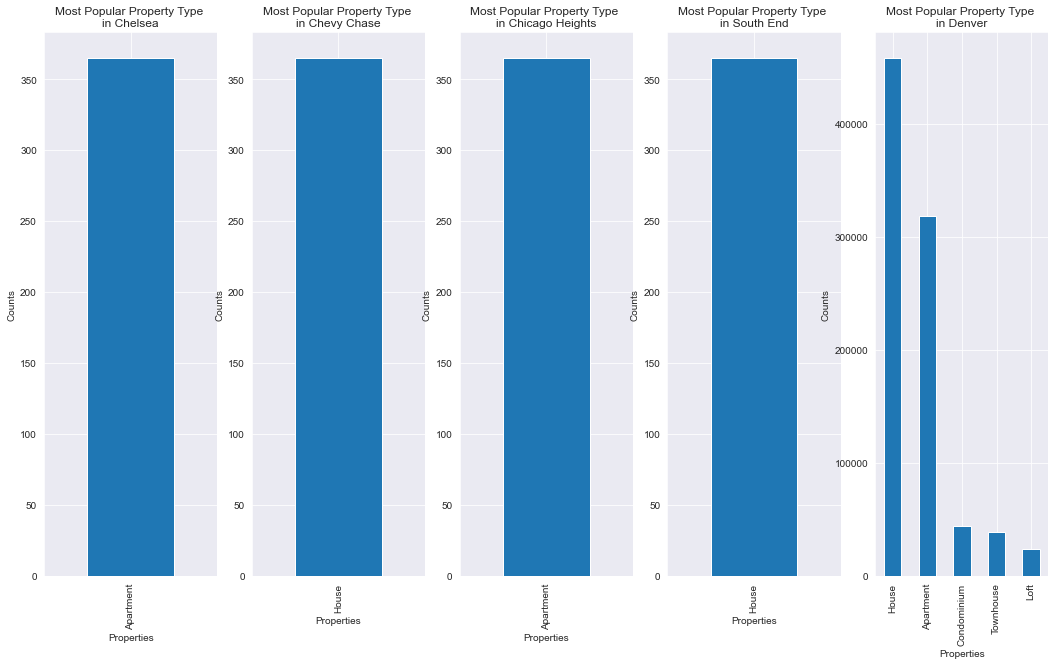

In [30]:
expensiveNeighbourhoods = [chelsea, chevyChase, chicagoHeights, southEnd, denver]
names = ['Chelsea', 'Chevy Chase', 'Chicago Heights', 'South End', 'Denver']
plt.figure(figsize = (18,10))
for i, var in enumerate(expensiveNeighbourhoods):
    plt.subplot(1,5,i+1)
    var.groupby(['property_type'])['id'].count().sort_values(ascending = False)[:5].plot(kind = "bar")
    plt.title(f"Most Popular Property Type \nin {names[i]}")
    plt.ylabel('Counts')
    plt.xlabel('Properties')

So we can see in these expensive neighbourhoods, apartments and houses are the main properties types

### Can we see trends across the most popular neighbourhoods in each metropolitan?

Most popular neighbourhoods can give us a good insight as to why people choose to rent out in these areas rather than other areas. We can look at what are the most popular property types, does the number of bedrooms play a factor as to why these are popular etc. Let us proceed with our analysis. Let us take a look at the top 5 neighbourhood locations for each metropolitan.

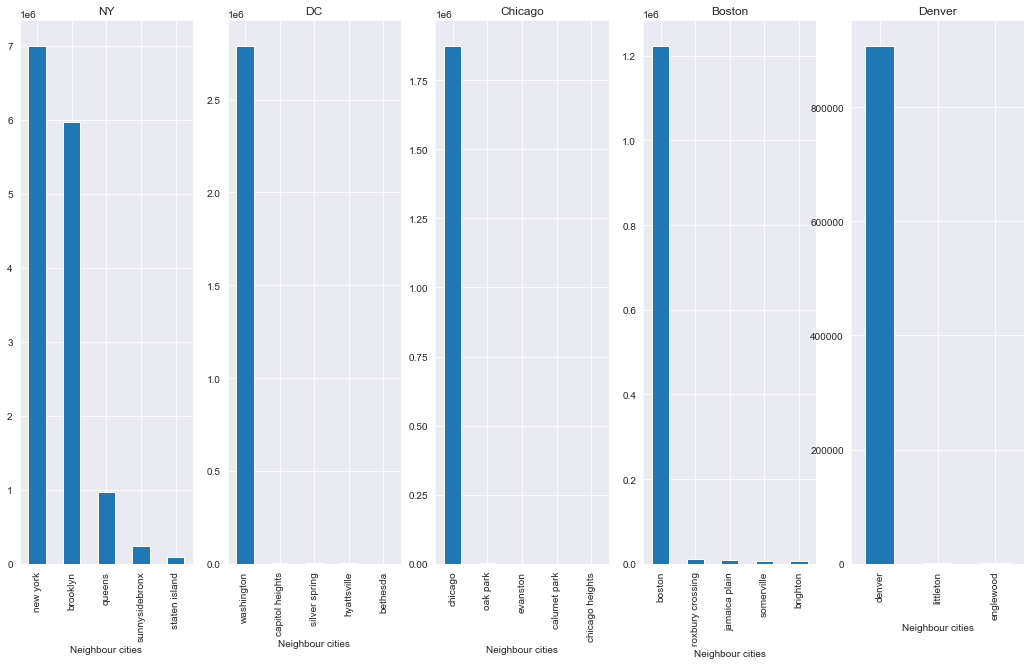

In [72]:
metro = [NY, DC, Chicago, Boston, Denver]
names = ['NY', 'DC', 'Chicago', 'Boston', 'Denver']
plt.figure(figsize = (18,10))
for i, var in enumerate(metro):
    plt.subplot(1,5,i+1)
    city = var.groupby(['city'])['id'].count().sort_values(ascending = False)[:5]
    city.plot(kind = "bar")
    title_string = f"{names[i]}"
    plt.title(title_string)
    plt.xlabel('Neighbour cities')

As expected, we see that the major cities are the most popular rental spots. Let us see if we can indentify any trends over time that may explain why these cities are the most popular.

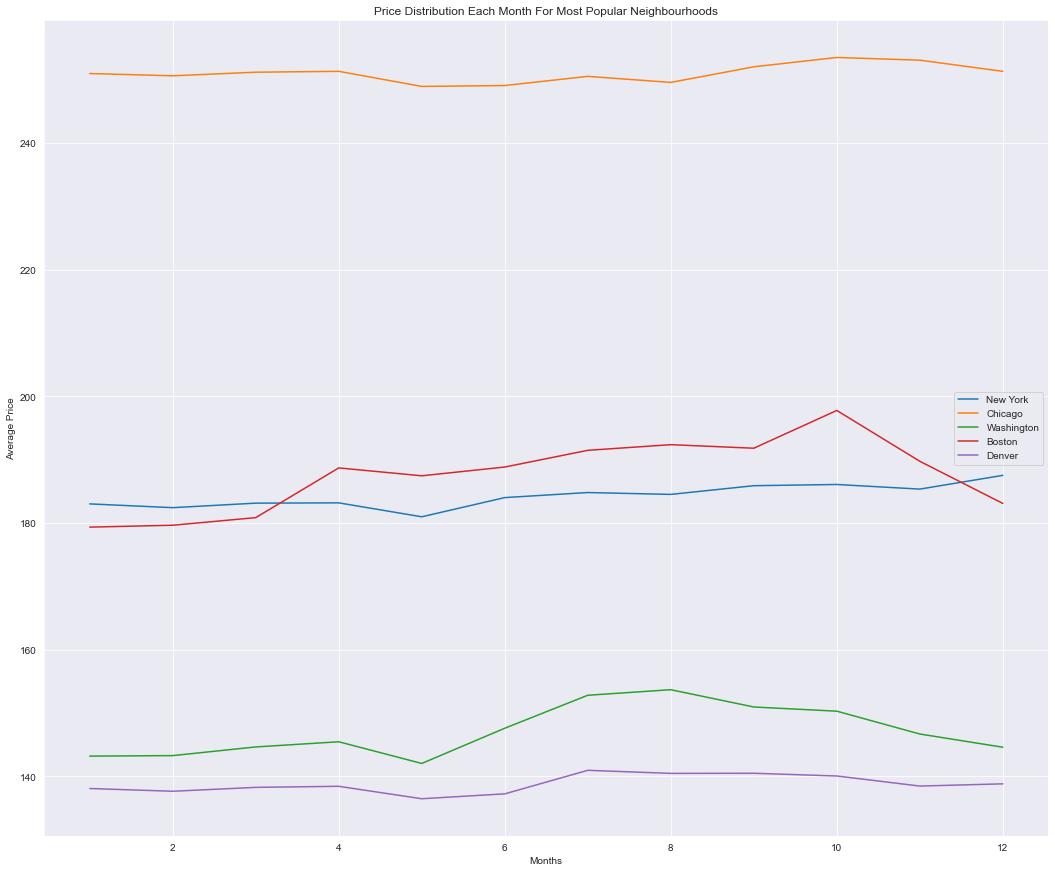

In [73]:
newyork = NY[NY['city'] == 'new york'].reset_index(drop = True)
washington = DC[DC['city'] == 'washington'].reset_index(drop = True)
chicago = Chicago[Chicago['city'] == 'chicago'].reset_index(drop = True)
boston = Boston[Boston['city'] == 'boston'].reset_index(drop = True)
denver = Denver[Denver['city'] == 'denver'].reset_index(drop = True)

popularNeighbourhoods = [newyork, washington, chicago, boston, denver]
names = ["New York", "Chicago", "Washington", "Boston", "Denver"]
plt.figure(figsize = (18,15))
for i, var in enumerate(popularNeighbourhoods):
    city = var.groupby(['month'])['price_calendar'].mean()
    city.plot(kind = "line")
    plt.title(f"Price Distribution Each Month For Most Popular Neighbourhoods")
    plt.xlabel("Months")
    plt.ylabel('Average Price')
    plt.legend(names)

There are certain trends we can definitely see in this graph. We see price increases during the summer (around the month of May) for almost all the cities except for Chicago, which seems to be pretty stable through the months. Except for New York and Chicago, we see price decreasing once October starts. We can also see that Chicago is clearly outstripping everyone when it comes to rental prices on average, while New York and Boston seems to be at the same level, and Denver and Washington are around the same level.

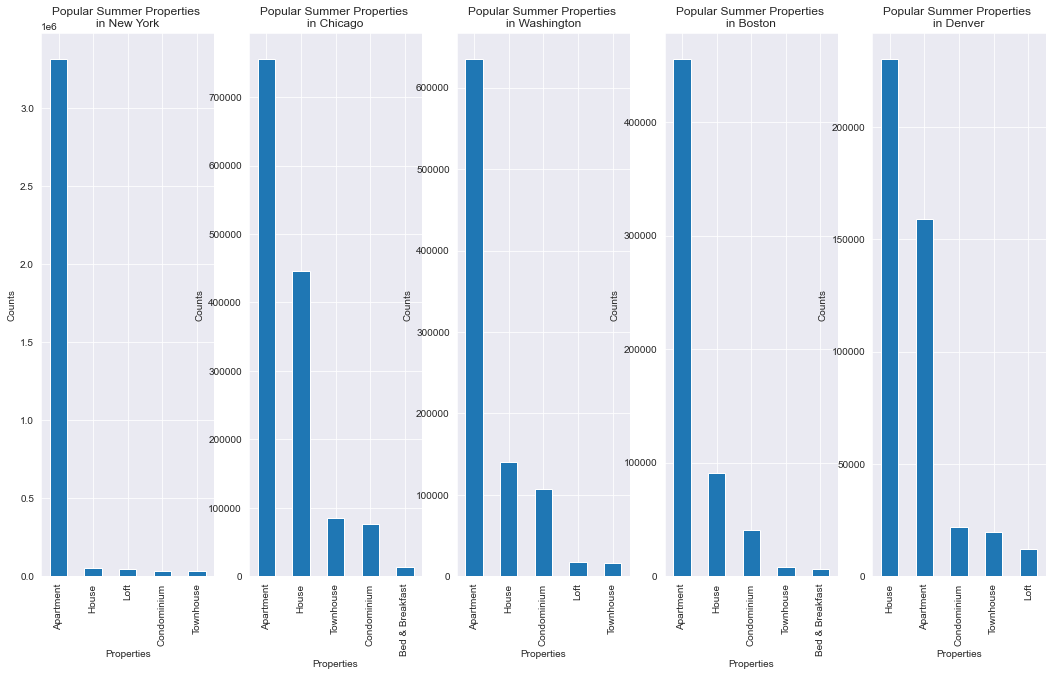

In [74]:
summerMonths = [5,6,7,8,9,10]
popularNeighbourhoodsSummer = []

for var in popularNeighbourhoods:
    summer =  var.loc[var['month'].isin(summerMonths)]
    popularNeighbourhoodsSummer.append(summer)

names = ["New York", "Chicago", "Washington", "Boston", "Denver"]
plt.figure(figsize = (18,10))
for i, var in enumerate(popularNeighbourhoodsSummer):
    plt.subplot(1,5,i+1)
    var.groupby(['property_type'])['id'].count().sort_values(ascending = False)[:5].plot(kind = "bar")
    plt.title(f"Popular Summer Properties \nin {names[i]}")
    plt.ylabel('Counts')
    plt.xlabel('Properties')

So it looks the most popular properties over the summer seem to be apartments in New York, Chicago, Washington and Boston, while for Denver it would be houses. We can assume that due to the high density of these 4 cities, it is pretty justifiable why apartments are the most popular airbnb rentals. We can also take a look at how the apartment prices have fluctuated throughout the summer.

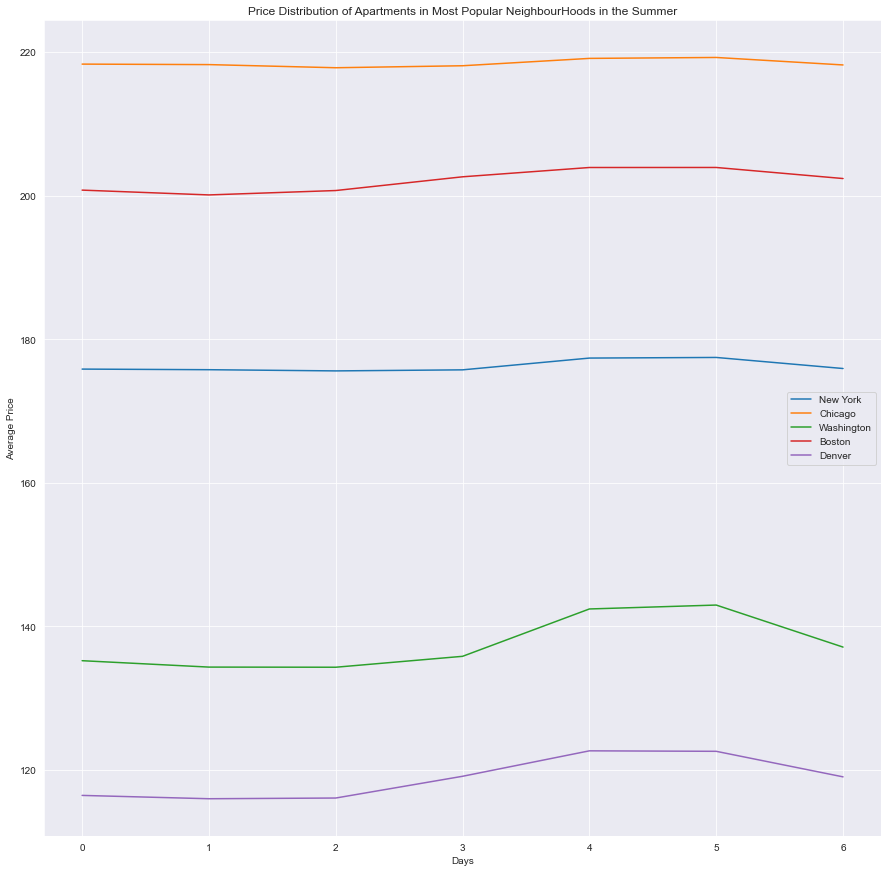

In [76]:
popularNeighbourhoodsSummer_apartments = []

for var in popularNeighbourhoodsSummer:
    summerApartments =  var.loc[var['property_type']== 'Apartment']
    popularNeighbourhoodsSummer_apartments.append(summerApartments)

names = ["New York", "Chicago", "Washington", "Boston", "Denver"]
plt.figure(figsize = (15,15))
for i, var in enumerate(popularNeighbourhoodsSummer_apartments):
    city = var.groupby(['day'])['price_calendar'].mean()
    city.plot(kind = "line")
    plt.title(f"Price Distribution of Apartments in Most Popular NeighbourHoods in the Summer")
    plt.xlabel("Days")
    plt.ylabel('Average Price')
    plt.legend(names)

As we can see above, when booking Airbnb apartments in the 5 popular cities, it looks the average price increases on Friday and Saturday. Several factors that could lead to this change in price is due to people want to spend the weekend outside. It makes sense that the prices would naturally be up due to the demand. As we can see, on Sunday the price goes back down as many people would be leaving their airbnbs rather than booking it for the last of day of the weekend.

## Regression Modelling

We believe using regression modelling is the best method for building a prediction model on this dataset. Our variable of interest is a continuous variable hence why regression  model seems the best and simplest method. Take note that we will not look at ```listing calendar``` dataset anymore due to number of data points in that dataset. Rather we will use the ```listing``` data set which already have a ton of valuable information. We can use the knowledge from all the EDA analysis of seeing trends to help us build a good prediction model.

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58994 entries, 0 to 59823
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            58994 non-null  object 
 1   availability_30         58994 non-null  int64  
 2   bed_type                58994 non-null  object 
 3   bedrooms                58994 non-null  object 
 4   city                    58994 non-null  object 
 5   id                      58994 non-null  int64  
 6   instant_bookable        58994 non-null  object 
 7   latitude                58994 non-null  float64
 8   longitude               58994 non-null  float64
 9   metropolitan            58994 non-null  object 
 10  price                   58994 non-null  float64
 11  property_type           58994 non-null  object 
 12  review_scores_location  58994 non-null  float64
 13  review_scores_rating    58994 non-null  float64
 14  review_scores_value     58994 non-null

In [14]:
df = listings.copy()
dropCols = ['zipcode', 'state',
            'id', 'latitude', 'longitude']
df.drop(dropCols, inplace= True, axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58994 entries, 0 to 59823
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            58994 non-null  object 
 1   availability_30         58994 non-null  int64  
 2   bed_type                58994 non-null  object 
 3   bedrooms                58994 non-null  object 
 4   city                    58994 non-null  object 
 5   instant_bookable        58994 non-null  object 
 6   metropolitan            58994 non-null  object 
 7   price                   58994 non-null  float64
 8   property_type           58994 non-null  object 
 9   review_scores_location  58994 non-null  float64
 10  review_scores_rating    58994 non-null  float64
 11  review_scores_value     58994 non-null  float64
 12  room_type               58994 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 6.3+ MB


Take the log of price_calendar + 1 , to make it as normally distributed as possible.

Text(0.5, 1.0, 'Histogram of Calendar Prices')

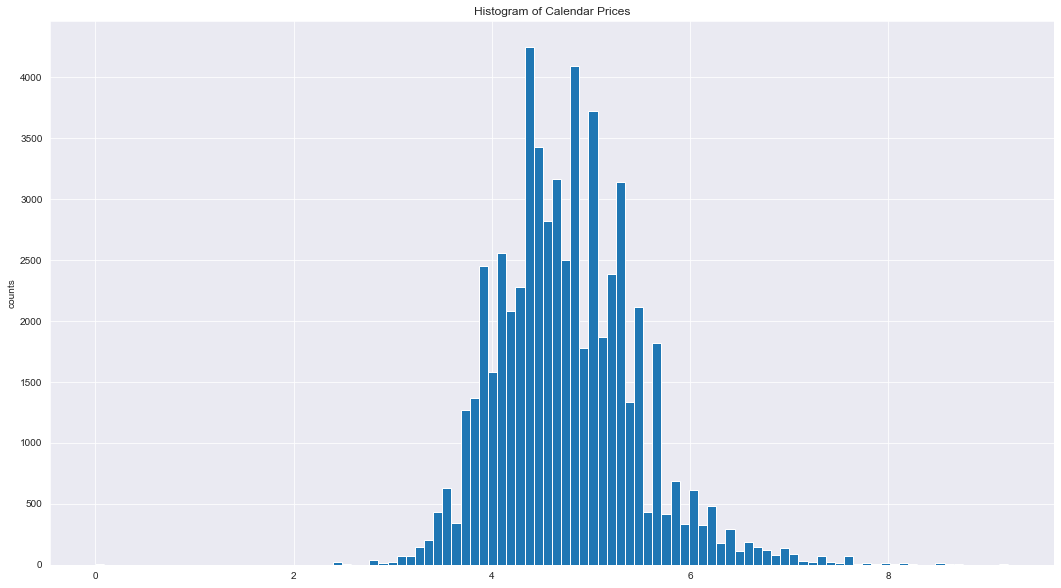

In [18]:
plt.figure(figsize = (18,10))
df['price_log'] = np.log(df['price'] + 1)
plt.hist(df['price_log'], bins = 100)
plt.ylabel("counts")
plt.title("Histogram of Calendar Prices")

Categorical Variables:
- accommodates,
- bed_type
- bedrooms
- city
- instant_bookable
- metropolitan
- property_type
- review_scores_location
- review_scores_value
- room_type

We will also convert bedroom into a type int

In [19]:
df.columns

Index(['accommodates', 'availability_30', 'bed_type', 'bedrooms', 'city',
       'instant_bookable', 'metropolitan', 'price', 'property_type',
       'review_scores_location', 'review_scores_rating', 'review_scores_value',
       'room_type', 'price_log'],
      dtype='object')

In [20]:
cats = ['accommodates','bed_type','bedrooms', 'city', 'instant_bookable', 'metropolitan','property_type','review_scores_location','review_scores_value', 'room_type']

for col in cats:
    df[col] = df[col].astype('category')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58994 entries, 0 to 59823
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   accommodates            58994 non-null  category
 1   availability_30         58994 non-null  int64   
 2   bed_type                58994 non-null  category
 3   bedrooms                58994 non-null  category
 4   city                    58994 non-null  category
 5   instant_bookable        58994 non-null  category
 6   metropolitan            58994 non-null  category
 7   price                   58994 non-null  float64 
 8   property_type           58994 non-null  category
 9   review_scores_location  58994 non-null  category
 10  review_scores_rating    58994 non-null  float64 
 11  review_scores_value     58994 non-null  category
 12  room_type               58994 non-null  category
 13  price_log               58994 non-null  float64 
dtypes: category(10), float

In [22]:
##Split the data into training and testing on a proportion of 8:2
np.random.seed(1)
size = len(df)
train = np.random.choice(range(size), int(0.8*size), replace = False)
test = np.asarray(list(set(range(size)) - set(train)))
dfTrain = df.iloc[train]
dfTest = df.iloc[test]

### Correlation Map

In [23]:
dfTrain.head()

,accommodates,availability_30,bed_type,bedrooms,city,instant_bookable,metropolitan,price,property_type,review_scores_location,review_scores_rating,review_scores_value,room_type,price_log
16227,2.0,0,Real Bed,1.0,new york,f,NYC,85.0,Apartment,10.0,96.0,10.0,Private room,4.454347
15751,3.0,9,Real Bed,0.0,brooklyn,f,NYC,129.0,Apartment,9.0,87.0,9.0,Entire home/apt,4.867534
57777,3.0,7,Real Bed,1.0,washington,f,DC,58.0,House,9.0,83.0,9.0,Private room,4.077537
50366,2.0,0,Real Bed,1.0,boston,f,BOSTON,200.0,Apartment,10.0,100.0,10.0,Private room,5.303305
36706,2.0,8,Real Bed,1.0,new york,f,NYC,160.0,Apartment,10.0,94.0,10.0,Private room,5.081404


## Linear Regression:

We will only use a few of the variables, due to the large data size and not enough memory capacity. These will be our covariates:
- accommodates
- availability_30
- bed_type
- bedrooms
- city
- instant_bookable
- property_type
- review_scores_location
- room_type

Our dependent variable will be ```price_calendar_log```.

Model Assumptions:
- errors are independent and identically distributed with mean 0 and variance $\sigma^2$ which does not depend on any of the covariates we choose.
- The probability distribution of the errors is Normal ( we solved this by taking the log of the prices)


**Model**
$\mathbf{price} = \beta_0 + \beta_1\times \mathbf{accommodates} + \beta_2\times \mathbf{availability 30} + \beta_3 \times \mathbf{bed type} + \dots + \beta_9 \times \mathbf{room type} $

In [24]:
model= smf.ols(formula='price_log ~accommodates + availability_30 + bed_type + bedrooms + city + instant_bookable + property_type + review_scores_location + room_type ', data = dfTrain).fit()

In [25]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     341.2
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:18:39   Log-Likelihood:                -29563.
No. Observations:               47195   AIC:                         5.953e+04
Df Residuals:                   46994   BIC:                         6.129e+04
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

As we can see the summary from above, we have an $R^2$ of $0.592 \approx 6$.Although this is a pretty decent way to see whether the model is a good one, we still need to check the residuals plot to make sure everything is correct.

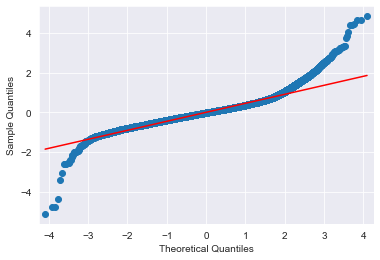

In [26]:
resid = model.resid
sm.qqplot(resid, line = "s");

As we can see on the above plot there seems to be heaviness on the tails, especially the right side. However, we do not see any sense of non-linearity in the quantile points, which means we do not need to do a transformation so far.

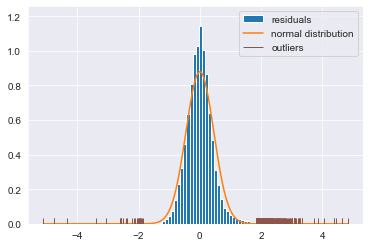

In [44]:
plt.hist(model.resid,
         density=True,     # the histogram integrates to 1
         # (so it can be compared to the normal distribution)
         bins=100,         #  draw a histogram with 100 bins of equal width
         label="residuals" # label for legend
         )
# now plot the normal distribution for comparison
xx = np.linspace(model.resid.min(), model.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model.scale)),
         label="normal distribution")
outliers = np.abs(model.resid)>4*np.sqrt(model.scale)
sns.rugplot(model.resid[outliers],
            color="C5", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

Another plot of show how the errors are normally distributed.

Text(0, 0.5, 'Actual Values')

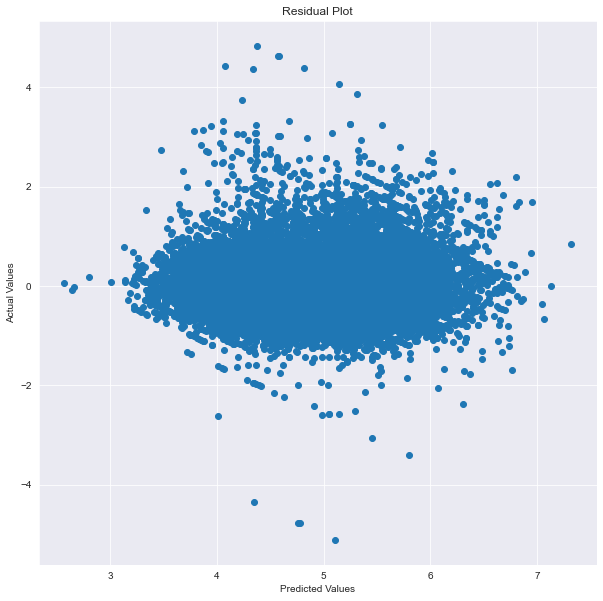

In [47]:
pred = model.fittedvalues.copy()
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(pred, resid)
plt.title("Residual Plot")
plt.xlabel('Predicted Values')
plt.ylabel("Actual Values")

As we can see, the residuals do not resemble any sort of clear shape. This indicates that the variance is not getting bigger. Furthermore, we can see that generally most of the points are hovering around the 0 axis, which means that our zero mean assumption should hold.

In [53]:
p_values = pd.DataFrame(model.pvalues).reset_index()
p_values.columns = ["coef", "p value"]
p_values[p_values['p value']<=0.05].sort_values(by=['p value'])

,coef,p value
206,availability_30,0.000000e+00
204,room_type[T.Private room],0.000000e+00
205,room_type[T.Shared room],0.000000e+00
5,accommodates[T.6.0],2.423584e-306
3,accommodates[T.4.0],1.689849e-296
...,...,...
189,property_type[T.Tent],3.717827e-02
63,city[T.corona],3.768521e-02
74,city[T.englewood],4.075209e-02
49,city[T.bushwick],4.170111e-02


As we can see from the above output these are the most statistical significant variables:

- availability_30
- room_type
- accommodates
- bedrooms
- property_type
- city
- review_scores_location